In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
##ADD YOUR PATH TO CODE REPOS HERE

net = 'binary_inputs'
PATH_YANGNET = os.path.join(p,'code/sophie-nets',net) 
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools

In [2]:
figpath = os.path.join(PATH_YANGNET,'figures_sophie_tutorial_notebook')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
#WHERE IS THE NETWORK
data_folder = 'data/rnn/multitask/'+net+'/lr'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = str(0)
rule_trains = [rules_dict['basic'][1],rules_dict['basic'][3]]
rule_trains_str = '_'.join(rule_trains)

# net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
net_name = 'l2_w6_h6_'+rule_trains_str

m = os.path.join(p,data_folder,rnn_type,activation,init,
                 str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)

In [4]:
m = os.path.join(p,'code/sophie_nets',net,'data/all/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7l2_w7_h7_sig_rec0.05_sig_x0.1_w_rec_coeff9_delaygo_delayanti',seed)

In [5]:
m = '/Users/lauradriscoll/Documents/data/sophie_nets/binary_inputs/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0'


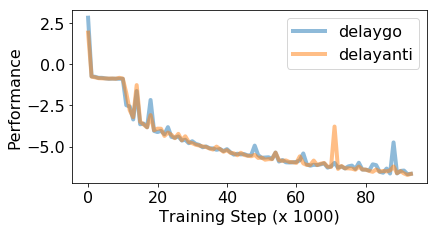

In [6]:
#LOOK AT PERFORMANCE OVER TRAINING

fig = plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 16})
ax_perf = plt.subplot(2,2,1)

fname = os.path.join(m, 'log.json')
with open(fname, 'r') as f:
    log_post = json.load(f)
for r in range(len(rule_trains)):

    plt.sca(ax_perf)
    x = log_post['cost_'+rule_trains[r]]
    plt.plot(np.log(x),'-',alpha = .5,linewidth = 4,label = rule_trains[r])
    ax_perf.set_xlabel('Training Step (x 1000)')
    ax_perf.set_ylabel('Performance')
    
plt.legend()

In [7]:
#THIS IS SOME GENERAL CODE THAT WILL GET YOU LOTS OF VARIABLES YOU'LL WANT TO LOOK AT

rule = 'fdgo' # SET A PARTICULAR TASK OF INTEREST

model = Model(m)
with tf.Session() as sess:
    model.restore()
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False,smooth_on = True, batch_size = 200)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #HIDDEN STATE, OUTPUT (n_TIME, n_TRIAL, n_UNIT)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/sophie_nets/binary_inputs/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/sophie_nets/binary_inputs/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt


Text(0,0.5,'activation')

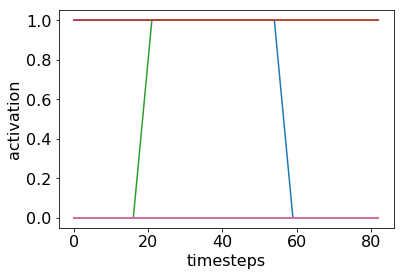

In [8]:
ti = 50 #trial number
ui = range(20) #unit number

# activity of single units through time
plt.plot(trial.x[:,2,:]) # time x trials x units
plt.xlabel('timesteps')
plt.ylabel('activation')

In [9]:
from scipy import ndimage as ndi
window = np.random.randint(10, 30)
smooth_x = ndi.uniform_filter1d(trial.x,size = window,axis = 0,mode = 'nearest')

Text(0,0.5,'activation')

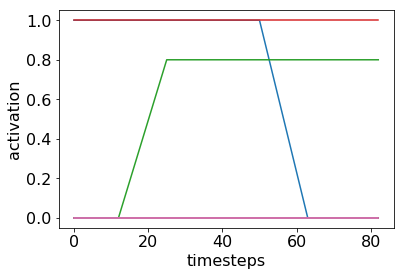

In [21]:
ti = 50 #trial number
ui = range(20) #unit number

# activity of single units through time
plt.plot(smooth_x[:,2,:]) # time x trials x units
plt.xlabel('timesteps')
plt.ylabel('activation')

In [10]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delayanti', hparams, mode='random', noise_on=False, batch_size = 50, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]  # [input weights , recurrent weights] 7+256, 256
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/sophie_nets/binary_inputs/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/sophie_nets/binary_inputs/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


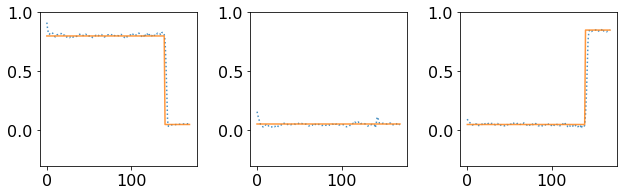

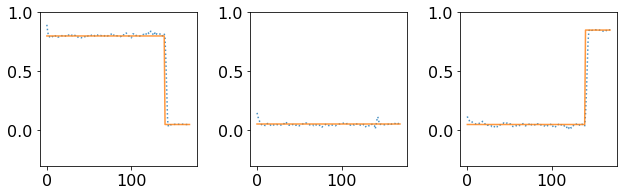

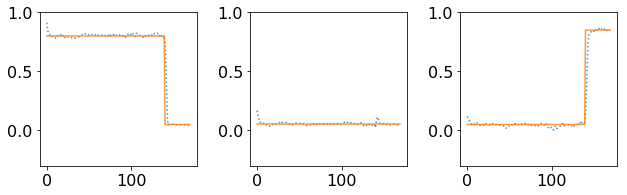

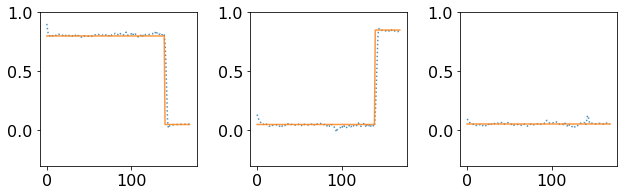

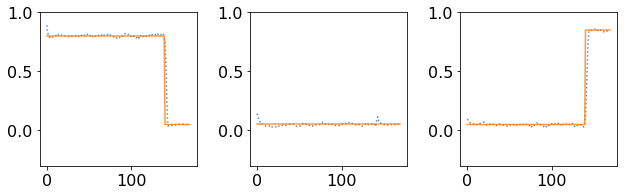

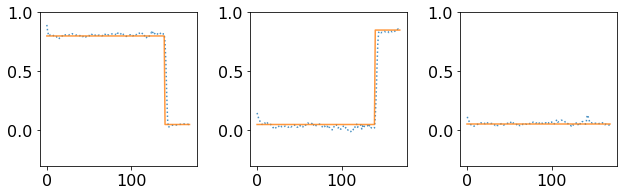

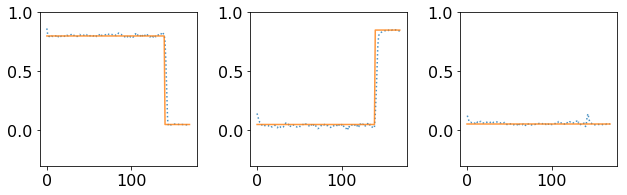

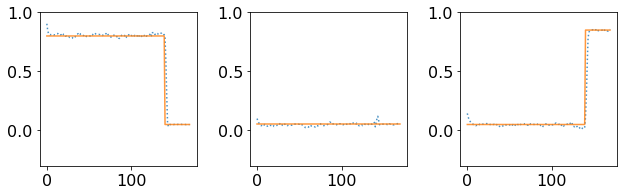

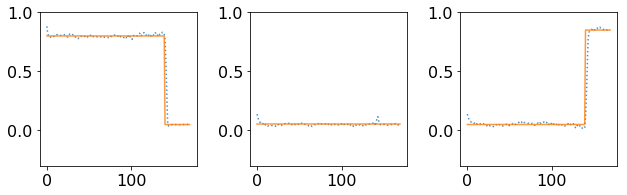

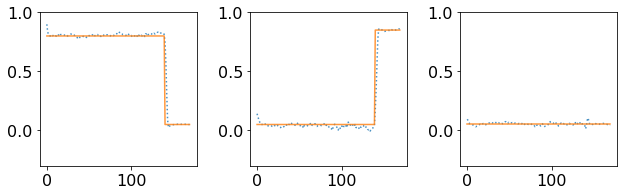

In [11]:
for ti in range(10):
    fig = plt.figure(figsize=(9,3),tight_layout=True,facecolor='white')
    for outi in range(3):
        plt.subplot(1,3,outi+1)
        plt.plot(y_hat_tf[:,ti,outi],':',alpha = .8)
        plt.plot(trial.y[:,ti,outi],'-',alpha = .8)
        plt.ylim([-.3,1])
    plt.show()


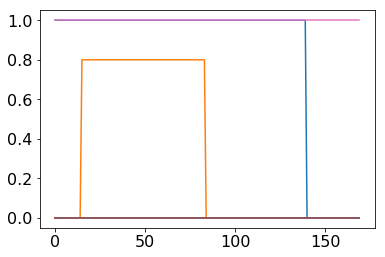

In [12]:
plt.plot(trial.x[:,0,:])
plt.show()

In [15]:
window = np.random.randint(0, 15)
print(window)

3


In [26]:
window = 30

In [27]:
from scipy import ndimage as ndi
smooth_x = ndi.uniform_filter1d(trial.x,size = window,axis = 0,mode = 'nearest')

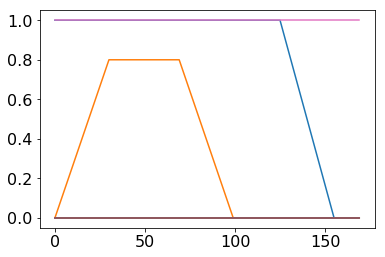

In [28]:

plt.plot(smooth_x[:,0,:])
plt.show()

In [102]:
smooth_x = np.emptytrial.x

window = 5
for trial_i in trial.x.shape[0]:
    for input_i in trial.x.shape[2]:
        smooth_x[trial_i,:,input_i] = np.convolve(trial.x[trial_i,:,input_i], np.ones(window)/window, mode='valid')

AttributeError: 'module' object has no attribute 'emptytrial'

In [26]:
# FUNCTION TO EXTRACT CONNECTION WEIGHTS

def get_model_params(model_dir,ckpt_n_dir = []):

    model = Model(model_dir)
    with tf.Session() as sess:
        if len(ckpt_n_dir)==0:
            model.restore()
        else:
            model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]

    w_in = params[0] # input weights (7) input units then (256) recurrent unit inputs)
    b_in = params[1] # input bias
    w_out = params[2] # ouput weights
    b_out = params[3] # output bias

    return w_in, b_in, w_out, b_out

In [27]:
from mpl_toolkits.mplot3d import Axes3D

def gen_trial_set(ri_set): # SAME STIM TRIALS FROM 2 DIFF TASKS
    rule1 = rule_trains[ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

def gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num): #MAKE AXES

    h_A = get_h_epoch(m,trial_set[ri_axs],epoch_list[ri_axs],trial_num[ri_axs])
    h_end = h_A[:,-1] - h_A[:,0]
    h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch_list[1-ri_axs],trial_num[1-ri_axs])
    h_diff = h_B[:,-1] - h_A[:,-1]

    D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
    D_fp_qr,_ = LA.qr(D_fp)
    
    return D_fp_qr

def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(n_stim_per_ring+1)

    rule1 = rule_trains[np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rule_trains[np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

def get_h_epoch(m,trial,epoch,t_num): #GET HIDDEN STATE TRAJECTORY FROM PARTICULAR TASK PERIOD
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = x[:,t_num,T_inds]
    return h_epoch

def find_closest_fp_loc(h_end,x_star):

    closest_fp = np.argmin([LA.norm(h_end - x_star[fp,:]) for fp in range(len(x_star))])
    closest_fp_loc = x_star[closest_fp,:]
        
    return closest_fp, closest_fp_loc

def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                        q_thresh = 1e-3,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1):

    fig_width = 10
    fig_height = 12
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    step_file = 'binary_nets_fp_interpolation'
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    tasks_str = '_'.join([rule_trains[ri_set[0]],rule_trains[ri_set[1]]])

    _, rule_name1, _, _ = take_names(epoch_list[0],rule_trains[ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rule_trains[ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rule_trains[ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0]
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rule_trains[ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:]) #distance between two closest (most relevant?) fps)

    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau'])

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 3, alpha = .5,linestyle = '-',c = c)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1, alpha = al,linestyle = '-',c = 'k')
        ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                       s = 20,c = 'k',marker = '^')
        ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                       s = 20,c = 'k',marker = 'x')

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
            CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
            CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
            if CA+CB < 1.2*AB: #only plotting fp in an ellipse around end of trajecory - better way to do this?
            
                dst_scale = 200 #messing around w scaling fps, make them HUUUGe
                
                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    facecolors='w' #unstable fps
                else:
                    facecolors=c #stable fps

                ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                              s = dst_scale, edgecolors = c, facecolors = facecolors, alpha = .8)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
    ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
    ax_fps.view_init(-153, -163)

    
    step_file='interp_h_clip'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = 'interp_stim_fps'+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax_fps

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=flo

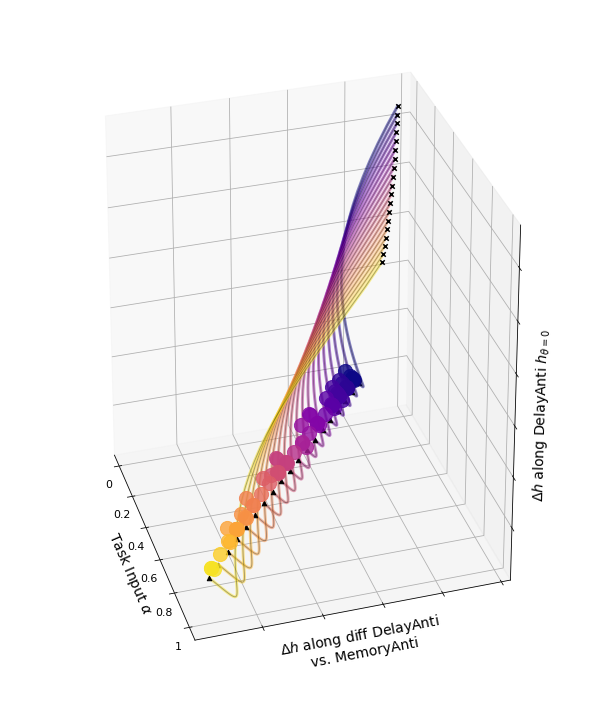

In [32]:
from tools_lnd import gen_trials_from_model_dir,make_FP_axs,take_names,same_stim_trial,\
gen_X_from_model_dir,get_T_inds,comp_eig_decomp

ri_set = [2,3]
trial_set = gen_trial_set(ri_set)
epoch_set = ['stim1','stim1']
trial_num = [0,0]
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=flo

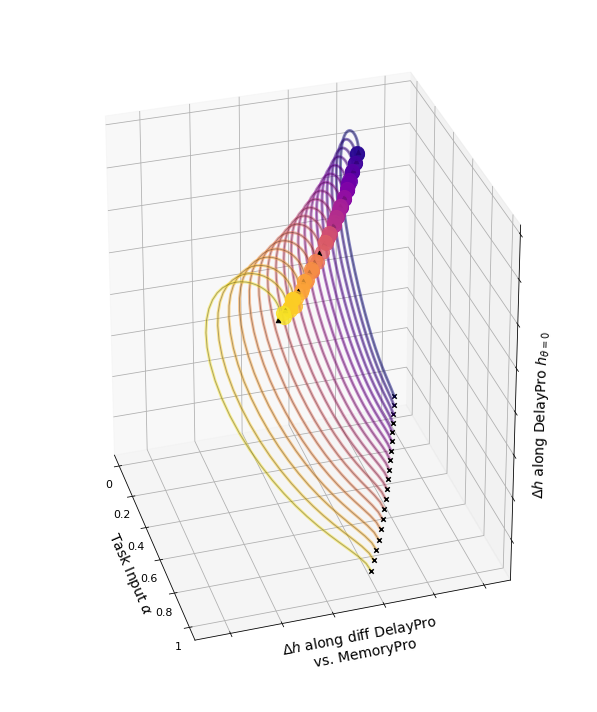

In [33]:
from tools_lnd import gen_trials_from_model_dir,make_FP_axs,take_names,same_stim_trial,\
gen_X_from_model_dir,get_T_inds,comp_eig_decomp

ri_set = [0,1]
trial_set = gen_trial_set(ri_set)
epoch_set = ['stim1','stim1']
trial_num = [0,0]
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/binary_inputs/lr/LeakyRNN/softplus/randgauss/4_tasks/256_n_rnn/l2_w6_h6_fdgo_delaygo_fdanti_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=flo

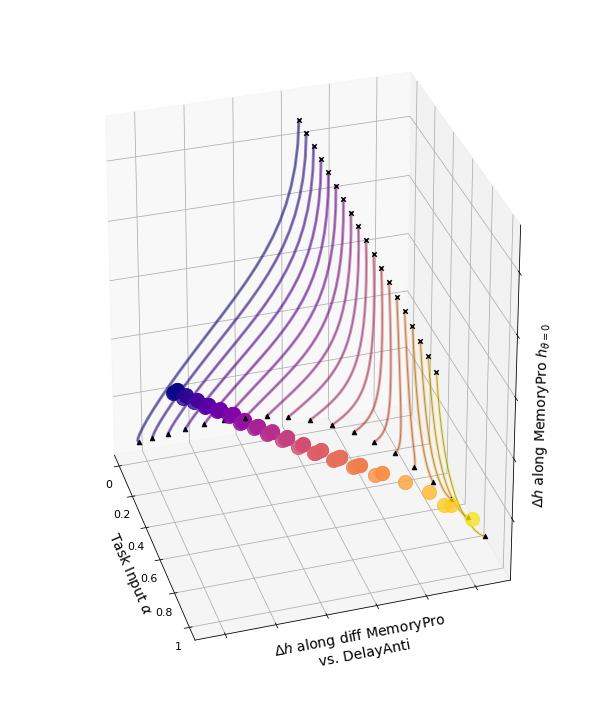

In [34]:
from tools_lnd import gen_trials_from_model_dir,make_FP_axs,take_names,same_stim_trial,\
gen_X_from_model_dir,get_T_inds,comp_eig_decomp

ri_set = [1,2]
trial_set = gen_trial_set(ri_set)
epoch_set = ['stim1','stim1']
trial_num = [0,0]
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)